In [22]:
%load_ext autoreload
%autoreload 2
import os
import pickle as pkl
import itertools
from functools import partial
from os.path import join as oj
from collections import defaultdict
import warnings

warnings.filterwarnings(action="ignore", category=UserWarning)

import imodels
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from imodels.util import data_util
from numpy import concatenate as npcat
from tqdm import tqdm
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn import metrics, model_selection
from sklearn.neighbors import KernelDensity
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 50)
mpl.rcParams['figure.dpi'] = 250
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Avenir']
mpl.rcParams['font.size'] = 16
np.random.seed(0)

# change working directory to project root
while os.getcwd().split('/')[-1] != 'imodels-experiments':
    os.chdir('..')

import viz
import validate

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
DATASET = 'tbi'
SPLIT_SEED = 0
RESULT_PATH = f'notebooks/transfertree/results/{DATASET}__/seed_{SPLIT_SEED}'
if not os.path.exists(RESULT_PATH):
    os.makedirs(RESULT_PATH)

In [3]:
X, y, feature_names = data_util.get_clean_dataset(f'{DATASET}_pecarn_pred.csv', data_source='imodels')
X_df = pd.DataFrame(X, columns=feature_names)

data/imodels_data/tbi_pecarn_pred.csv


### training propensity model

In [4]:
X_prop_raw, _, fnames_prop = data_util.get_clean_dataset(f'{DATASET}_pecarn_prop.csv', data_source='imodels', convertna=False)

data/imodels_data/tbi_pecarn_prop.csv


In [5]:
X_df_prop_raw = pd.DataFrame(X_prop_raw, columns=fnames_prop)
X_df_prop_raw['outcome'] = y

if DATASET == 'tbi':
    y_prop = X_df_prop_raw['AgeTwoPlus']
    X_df_prop = X_df_prop_raw.drop(columns=['AgeinYears', 'AgeInMonth', 'AgeTwoPlus', 'outcome'])
elif DATASET == 'csi':
    y_prop = (X_df_prop_raw['AgeInYears'] >= 2).astype(int)
    X_df_prop = X_df_prop_raw.drop(columns=['AgeInYears', 'outcome'])
elif DATASET == 'iai':
    y_prop = X_df_prop_raw['Age<2_no']
    X_df_prop = X_df_prop_raw.drop(columns=['Age', 'Age<2_no', 'Age<2_yes', 'outcome'])

X_prop = X_df_prop.values
X_prop_train_full, X_prop_test, y_prop_train_full, y_prop_test = model_selection.train_test_split(X_prop, y_prop, test_size=0.2, random_state=SPLIT_SEED)

In [6]:
prop_models = {}
prop_scores = {}
prop_models['L'] = LogisticRegression(C=2.783, penalty='l2', solver='liblinear')
prop_models['GB'] = GradientBoostingClassifier()

for m in prop_models:
    prop_models[m].fit(X_prop_train_full, y_prop_train_full)
    prop_scores[f'{m}_full'] = prop_models[m].predict_proba(X_prop_train_full)[:, 1]
    prop_scores[m] = model_selection.train_test_split(
        prop_scores[f'{m}_full'], test_size=0.25, random_state=SPLIT_SEED)[0]

### understanding propensity model

- main features that determine scores

In [7]:
nonzero_ind = np.nonzero(prop_models['L'].coef_[0])[0]
nonzero_ind_sorted = nonzero_ind[np.argsort(prop_models['L'].coef_[0][nonzero_ind])]
prop_model_coefs = pd.DataFrame(prop_models['L'].coef_[0][nonzero_ind_sorted], index=X_df_prop.columns[nonzero_ind_sorted])

In [8]:
important_prop_features = pd.concat((prop_model_coefs.iloc[:10], prop_model_coefs.iloc[-10:]))
important_prop_features.reset_index(inplace=True)
important_prop_features.columns = pd.Index(['Feature name', 'Coefficient'])
important_prop_features[::-1].style.background_gradient()

,Feature name,Coefficient
19,FontBulg_0.0,3.617127
18,Amnesia_verb_1.0,2.066327
17,InjuryMech_PedesMV,1.442824
16,HA_verb_1.0,1.386517
15,InjuryMech_BikeMV,1.258877
14,InjuryMech_Sports,1.252478
13,AMSRepeat_1,1.225020
12,SeizOccur_>30 minutes after injury,1.179105
11,HASeverity_Severe,0.993771
10,High_impact_InjSev_Moderate,0.944649


- distribution of scores

In [9]:
# X_df_prop_raw_train_full, X_df_test = model_selection.train_test_split(X_df_prop_raw, test_size=0.2, random_state=SPLIT_SEED)

# fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# for k, pmodel in enumerate(prop_models):
#     X_df_prop_raw_train_full['Transfer Score'] = prop_scores[f'{pmodel}_full']
#     if DATASET == 'iai':
#         X_df_prop_raw_train_full['AgeTwoPlus'] = X_df_prop_raw_train_full['Age<2_no']
#     elif DATASET == 'csi':
#         X_df_prop_raw_train_full['AgeTwoPlus'] = X_df_prop_raw_train_full['AgeInYears'] >= 2
#     sns.histplot(data=X_df_prop_raw_train_full, x='Transfer Score', hue='AgeTwoPlus', 
#         multiple='dodge', stat="density", common_norm=False, bins=30, ax=axes[k])
#     axes[k].set_title(pmodel)
# plt.tight_layout()

In [10]:
palette = ['tab:purple', 'tab:green']
palette = [sns.color_palette()[2], sns.color_palette()[4]]

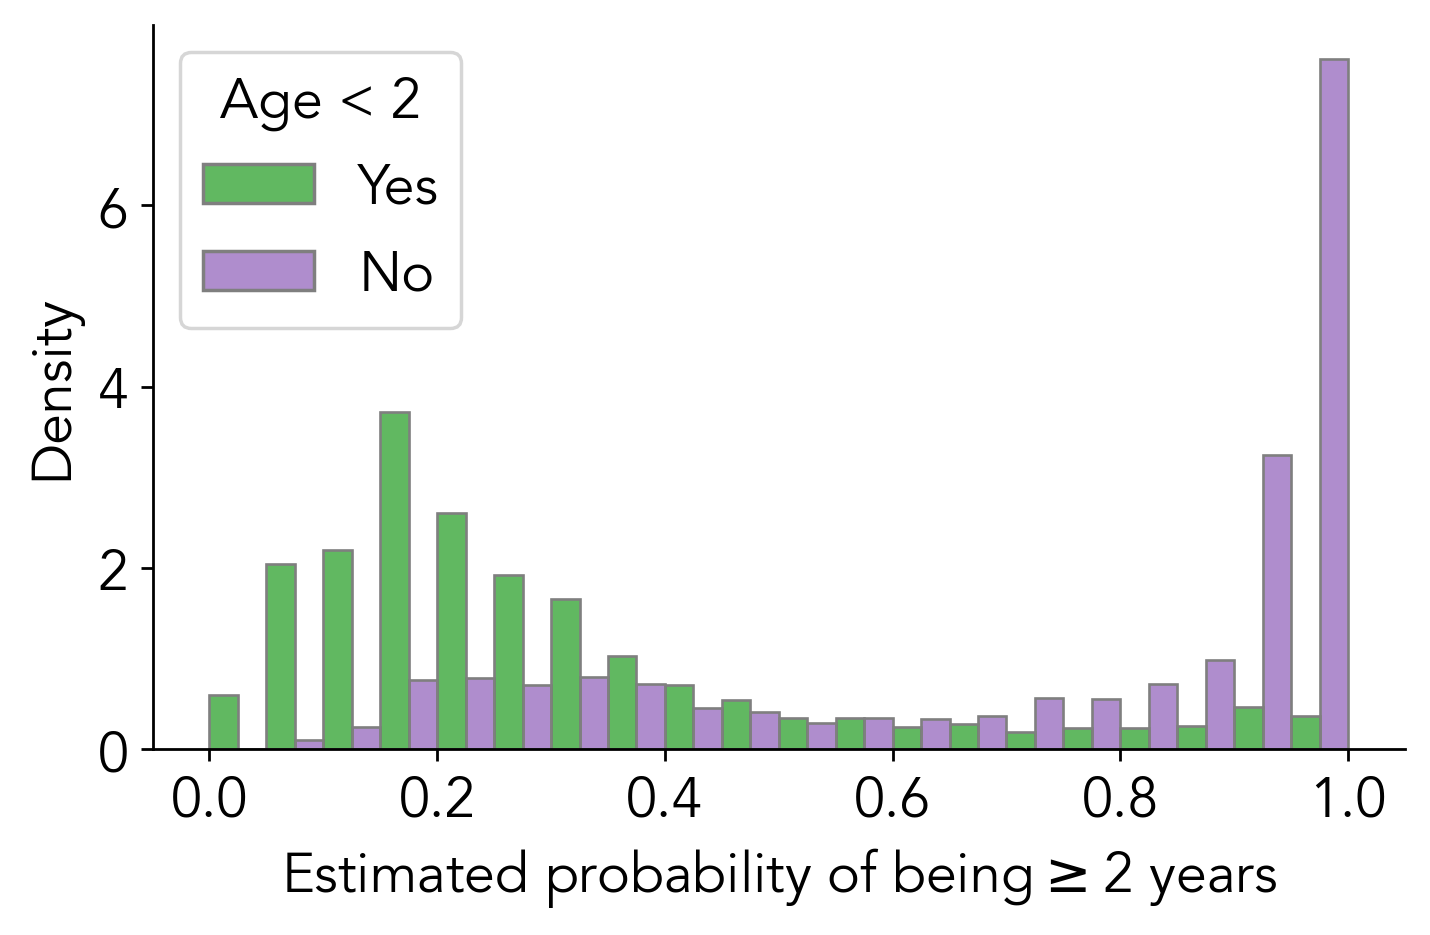

In [28]:
X_df_prop_raw_train_full, X_df_test = model_selection.train_test_split(X_df_prop_raw, test_size=0.2, random_state=SPLIT_SEED)
if DATASET == 'iai':
    X_df_prop_raw_train_full['AgeTwoPlus'] = X_df_prop_raw_train_full['Age<2_no']
    X_df_prop_raw_train_full['AgeinYears'] = X_df_prop_raw_train_full['Age']
elif DATASET == 'csi':
    X_df_prop_raw_train_full['AgeTwoPlus'] = (X_df_prop_raw_train_full['AgeInYears'] >= 2).astype(int)
    X_df_prop_raw_train_full['AgeinYears'] = X_df_prop_raw_train_full['AgeInYears']

less_than_6_ind = X_df_prop_raw_train_full['AgeinYears'] < 6
X_df_prop_raw_train_full = X_df_prop_raw_train_full[less_than_6_ind]
X_df_prop_raw_train_full['Transfer Score'] = prop_scores[f'L_full'][less_than_6_ind]

X_df_prop_raw_train_full['Age < 2'] = X_df_prop_raw_train_full['AgeTwoPlus'].replace({0.0: 'Yes', 1.0: 'No'})
sns.histplot(data=X_df_prop_raw_train_full, x='Transfer Score', hue='Age < 2', 
    multiple='dodge', stat="density", common_norm=False, bins=20, palette = palette,
    edgecolor = sns.color_palette()[7])
plt.tight_layout()
plt.xlabel('Estimated probability of being${\geq}$2 years')
plt.savefig(f'prop_scores_hist_{DATASET}.pdf')

- relationship between scores and age in months

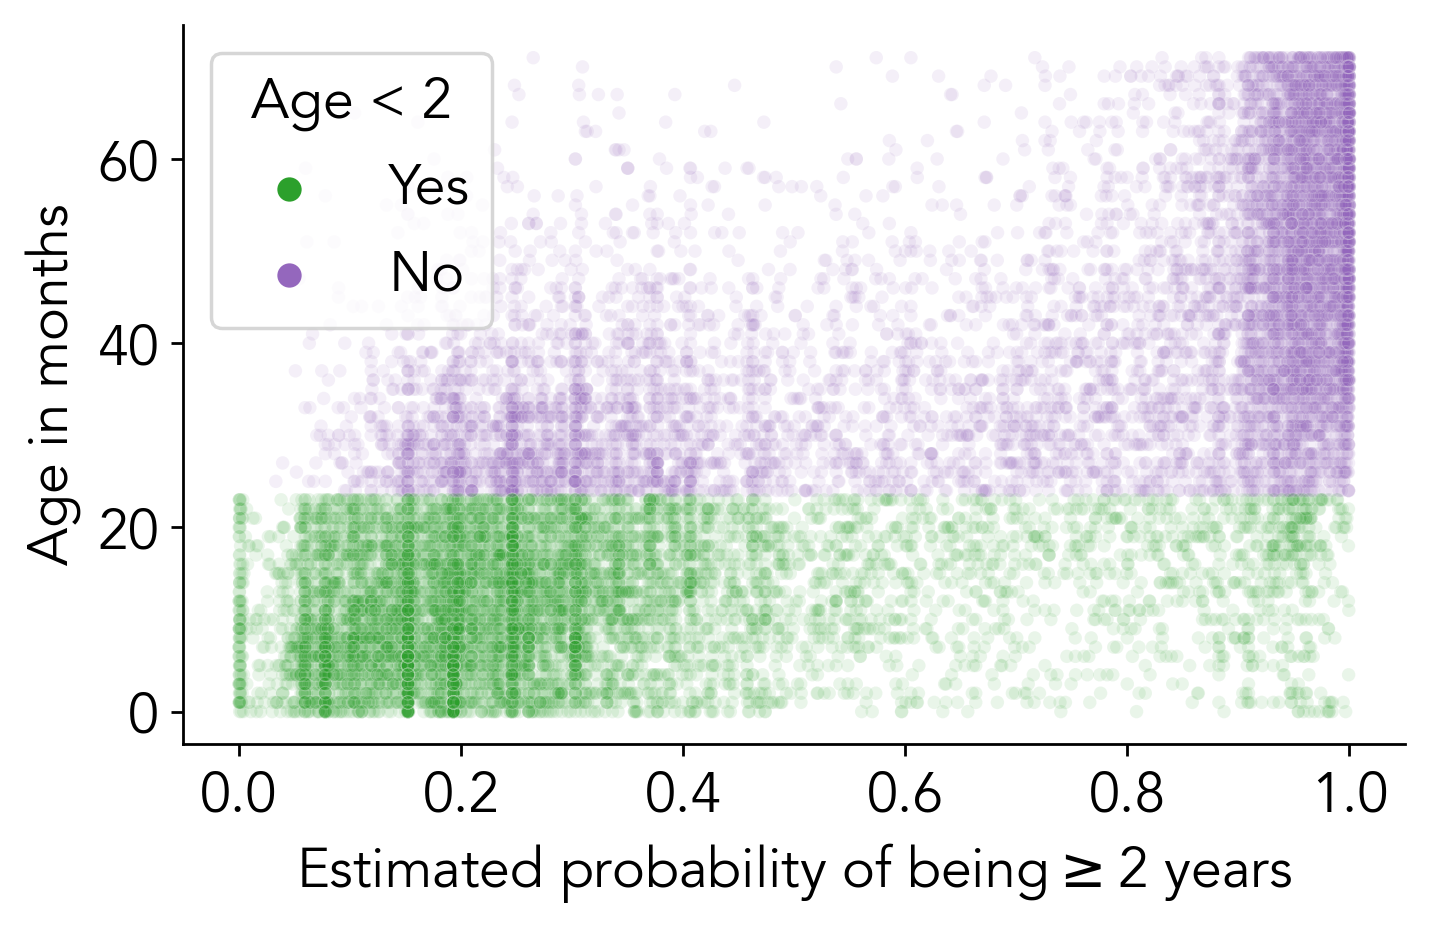

In [31]:
if DATASET == 'csi':
     y_scat='AgeInYears'
else:
     y_scat='AgeInMonth'

sns.scatterplot(
     data=X_df_prop_raw_train_full, x='Transfer Score', y=y_scat, 
     hue = 'Age < 2', alpha=0.10, s=15, palette=palette)

plt.ylabel('Age in months')
plt.xlabel('Estimated probability of being${\geq}$2 years')
plt.tight_layout()
plt.savefig(f'prop_scores_scatter_{DATASET}.pdf')

- possible further analysis: dig into the cluster of patients with age over two with prop scores in (0.1, 0.4) seen above